In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('../data/processed/market_features.csv', index_col=0, parse_dates=True)

# --- FEATURE 1: RELATIVE STRENGTH INDEX (RSI) ---
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# We calculate RSI on the Close price
# Note: We need to reconstruct a 'Close' column roughly from the Log Returns 
# or just use the existing SPY_Close if available. 
# Let's check if SPY_Close is in the columns.
if 'SPY_Close' in df.columns:
    df['RSI'] = calculate_rsi(df['SPY_Close'])
else:
    print("⚠️ SPY_Close column missing. Please check data_processing.py")

# --- FEATURE 2: BOLLINGER BANDS (Mean Reversion) ---
def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

if 'SPY_Close' in df.columns:
    df['BB_Upper'], df['BB_Lower'] = calculate_bollinger_bands(df['SPY_Close'])
    
    # Crucial: Create a "Distance" feature for the model
    # How close are we to the upper band? (Higher = More Risk of Pullback)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['SPY_Close']
    df['Dist_to_Upper'] = df['SPY_Close'] - df['BB_Upper']

# --- FEATURE 3: MOMENTUM (Changes) ---
# Is the 50-day trend above the 200-day trend? (Golden Cross logic)
df['SMA_50'] = df['SPY_Close'].rolling(window=50).mean()
df['SMA_200'] = df['SPY_Close'].rolling(window=200).mean()
df['Trend_Signal'] = (df['SMA_50'] > df['SMA_200']).astype(int)

# Drop NaNs generated by the 200-day lookback
df_engineered = df.dropna()

print(f"New Features Added. Data shape: {df_engineered.shape}")
df_engineered.tail()

New Features Added. Data shape: (758, 13)


,SPY_Close,^VIX_Close,SPY_Log_Ret,SPY_Vol_30d,SPY_SMA_50,RSI,BB_Upper,BB_Lower,BB_Width,Dist_to_Upper,SMA_50,SMA_200,Trend_Signal
Date,,,,,,,,,,,,,
2023-12-22,463.589172,13.03,0.002008,0.101375,434.895891,75.168287,468.229838,436.081438,0.069347,-4.640666,434.895891,420.263284,1
2023-12-26,465.546631,12.99,0.004214,0.094396,435.794243,76.604609,469.812128,436.750800,0.071016,-4.265497,435.794243,420.730727,1
2023-12-27,466.388397,12.43,0.001806,0.093808,436.620917,80.795909,471.268720,437.586172,0.072220,-4.880323,436.620917,421.205030,1
2023-12-28,466.564545,12.47,0.000378,0.079996,437.451504,78.999371,472.394584,438.801080,0.072002,-5.830039,437.451504,421.649507,1
2023-12-29,465.213898,12.45,-0.002899,0.081324,438.368351,74.637102,473.141277,440.085602,0.071055,-7.927380,438.368351,422.099041,1


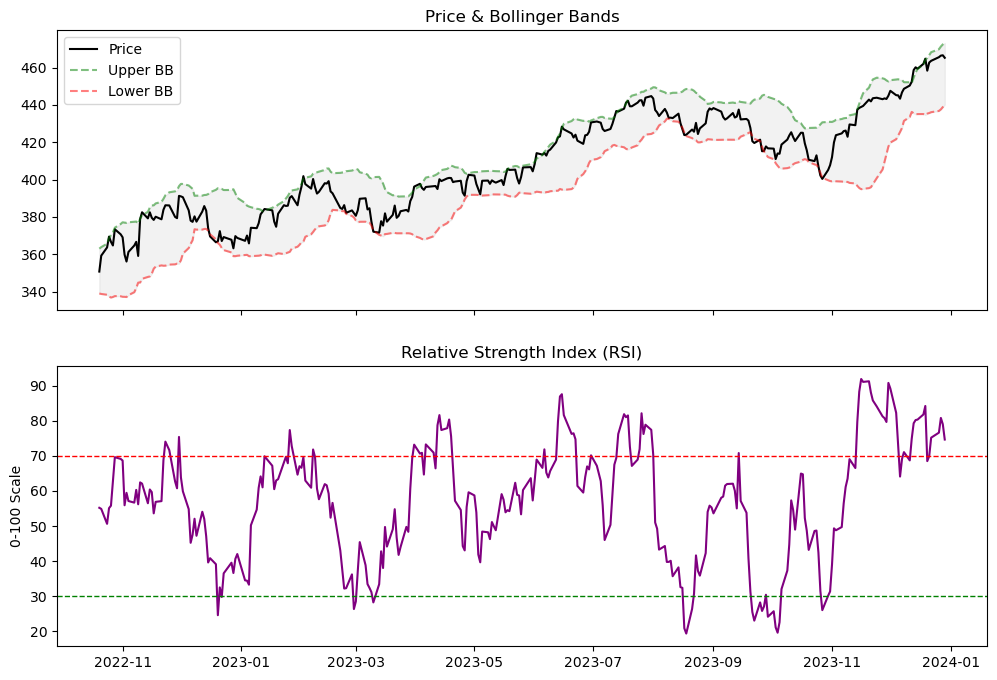

In [5]:
# Plot Last 300 Days to see the indicators clearly
subset = df_engineered.iloc[-300:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Price + Bollinger Bands
ax1.plot(subset.index, subset['SPY_Close'], label='Price', color='black')
ax1.plot(subset.index, subset['BB_Upper'], label='Upper BB', color='green', linestyle='--', alpha=0.5)
ax1.plot(subset.index, subset['BB_Lower'], label='Lower BB', color='red', linestyle='--', alpha=0.5)
ax1.fill_between(subset.index, subset['BB_Upper'], subset['BB_Lower'], color='gray', alpha=0.1)
ax1.set_title("Price & Bollinger Bands")
ax1.legend()

# Plot 2: RSI
ax2.plot(subset.index, subset['RSI'], label='RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--', linewidth=1)
ax2.axhline(30, color='green', linestyle='--', linewidth=1)
ax2.set_title("Relative Strength Index (RSI)")
ax2.set_ylabel("0-100 Scale")

plt.show()

In [6]:
# Create the target again for correlation check
df_engineered['Target_Return'] = df_engineered['SPY_Log_Ret'].shift(-1)

# Calculate correlation with the Target
correlations = df_engineered.corr()['Target_Return'].sort_values()

print("Correlation with Tomorrow's Return:")
print(correlations)

Correlation with Tomorrow's Return:
SPY_Close       -0.075793
BB_Upper        -0.065376
BB_Lower        -0.061615
SMA_200         -0.057020
SPY_SMA_50      -0.052444
SMA_50          -0.052444
Dist_to_Upper   -0.026181
RSI             -0.025134
SPY_Vol_30d     -0.016914
SPY_Log_Ret      0.003614
BB_Width         0.006993
^VIX_Close       0.035275
Trend_Signal     0.037678
Target_Return    1.000000
Name: Target_Return, dtype: float64


/var/folders/6f/5w5q3xqx3s96c8h0wslb5zt00000gp/T/ipykernel_14132/2668622070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_engineered['Target_Return'] = df_engineered['SPY_Log_Ret'].shift(-1)


In [7]:
output_path = '../data/processed/market_features_v2.csv'
df_engineered.to_csv(output_path)
print(f"✅ Advanced feature set saved to {output_path}")

✅ Advanced feature set saved to ../data/processed/market_features_v2.csv
